In [0]:
from pyspark.sql import SparkSession # Importing SparkSession
spark = SparkSession.builder.appName('MachineLearning').getOrCreate() #Creating a SPARK instance

In [0]:
titanic = spark.read.csv('/FileStore/tables/titanic.csv', inferSchema=True, header=True) # Reading the dataset
print("Shape of the df is",titanic.count() ,len(titanic.columns)) # Printing the shape

Shape of the df is 891 12

In [0]:
titanic.describe().show() #Descriptive Statistics

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
summary| PassengerId| Survived| Pclass| Name| Sex| Age| SibSp| Parch| Ticket| Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
 count| 891| 891| 891| 891| 891| 714| 891| 891| 891| 891| 204| 889|
 mean| 446.0| 0.3838383838383838| 2.308641975308642| null| null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.2042079685746| null| null|
 stddev|257.3538420152301|0.48659245426485753|0.8360712409770491| null| null|14.526497332334035|1.1027434322934315| 0.8060572211299488|471609.26868834975|49.69342859718089| null| null|
 min| 1| 0| 1|"Andersson, Mr. A...|female| 0.42| 0| 0| 110152| 0.0| A10| C|
 max| 891| 1| 3|van Melkebeke, Mr...| male| 80.0| 8| 6| WE/P 5735| 512.3292| T| S|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+

In [0]:
titanic.printSchema() # Print Schema is more like the info function

root
-- PassengerId: integer (nullable = true)
-- Survived: integer (nullable = true)
-- Pclass: integer (nullable = true)
-- Name: string (nullable = true)
-- Sex: string (nullable = true)
-- Age: double (nullable = true)
-- SibSp: integer (nullable = true)
-- Parch: integer (nullable = true)
-- Ticket: string (nullable = true)
-- Fare: double (nullable = true)
-- Cabin: string (nullable = true)
-- Embarked: string (nullable = true)

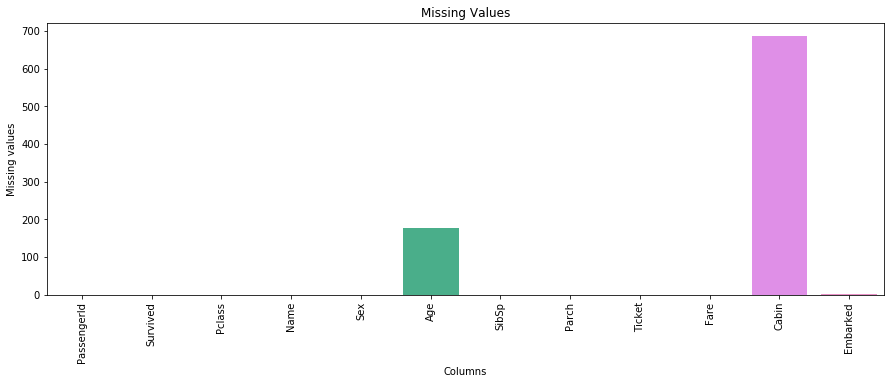

In [0]:
def missing_values(titanic):
  missing_values = {}
  for i in titanic.columns:
    missing_values[i] = titanic.count() - titanic.na.drop(subset=[i]).count()
  import pandas as pd
  import seaborn as sns
  import matplotlib.pyplot as plt
  mvs = pd.DataFrame(missing_values, index = [0]).T
  plt.figure(figsize = (15,5))
  plt.title('Missing Values')
  sns.barplot(x = mvs.index , y = mvs[0])
  plt.xlabel("Columns")
  plt.ylabel("Missing values")
  plt.xticks(rotation= 90)
  plt.show()
missing_values(titanic)

In [0]:
titanic.columns # Columns in the dataset

Out[15]: ['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [0]:
# Creating a final df for the ML ops
my_cols = ['Survived',
 'Pclass','Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare','Embarked']
fin_df = titanic[my_cols].na.drop()
fin_df.show(5)

+--------+------+------+----+-----+-----+----------------+-------+--------+
Survived|Pclass| Sex| Age|SibSp|Parch| Ticket| Fare|Embarked|
+--------+------+------+----+-----+-----+----------------+-------+--------+
 0| 3| male|22.0| 1| 0| A/5 21171| 7.25| S|
 1| 1|female|38.0| 1| 0| PC 17599|71.2833| C|
 1| 3|female|26.0| 0| 0|STON/O2. 3101282| 7.925| S|
 1| 1|female|35.0| 1| 0| 113803| 53.1| S|
 0| 3| male|35.0| 0| 0| 373450| 8.05| S|
+--------+------+------+----+-----+-----+----------------+-------+--------+
only showing top 5 rows

In [0]:
# Using the display funtion to plot pyspark dataframes
from pyspark.sql.functions import format_number, countDistinct
fin_df.select(countDistinct('Embarked')).show()
print("==========Number of Passengers under each category in Embarked============")
display(fin_df.groupby('Embarked').count())

+------------------------+
count(DISTINCT Embarked)|
+------------------------+
 3|
+------------------------+

==========Number of Passengers under each category in Embarked============

Embarked,count
Q,28
C,130
S,554


In [0]:
fin_df.select(countDistinct('Sex')).show()
print("==========Number of Passengers under each category in Sex============")
display(fin_df.groupby('Sex').count())

+-------------------+
count(DISTINCT Sex)|
+-------------------+
 2|
+-------------------+

==========Number of Passengers under each category in Sex============

Sex,count
female,259
male,453


In [0]:
fin_df.select(countDistinct('Sibsp')).show()
print("==========Number of Passengers travelled with Number of sibilings/spouse============")
display(fin_df.groupby('Sibsp').count())

+---------------------+
count(DISTINCT Sibsp)|
+---------------------+
 6|
+---------------------+

==========Number of Passengers travelled with Number of sibilings/spouse============

Sibsp,count
1,183
3,12
5,5
4,18
2,25
0,469


In [0]:
fin_df.select(countDistinct('Survived')).show()
print("=========================================== Survived vs Fatal =================================================")
display(fin_df.groupby('Survived').count())

+------------------------+
count(DISTINCT Survived)|
+------------------------+
 2|
+------------------------+

=========================================== Survived vs Fatal =================================================

Survived,count
1,288
0,424


In [0]:
# Importing Lableencoder and Onehotencoder 
# Vectorassembler to change the df to a spark ML acceptable format
from pyspark.ml.feature import (VectorAssembler, VectorIndexer,
                               OneHotEncoder, StringIndexer)

In [0]:
# one hot encoding the gender
gen_indexer = StringIndexer(inputCol = 'Sex',outputCol = 'SexIndex') # Lable indexing the sting categories
gen_one_hot_encode = OneHotEncoder(inputCol= 'SexIndex', outputCol= 'Sexvector') # One hot encoding the levels of the categorical variable

# Embarked (Onehot encoding Embarked)
emb_indexer = StringIndexer(inputCol = 'Embarked',outputCol = 'EmIndex')
emb_one_hot_encode = OneHotEncoder(inputCol= 'EmIndex', outputCol= 'Embvector')


In [0]:
fin_df.columns

Out[52]: ['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked']

In [0]:
# assembler Inside the assembler we define the dependent and the independent varibales
assembler = VectorAssembler(inputCols=['Pclass',
 'Sexvector',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embvector'],outputCol='features')

In [0]:
# Defining the dependent and independent fetures while creating the isntance of the LG class
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol='features',labelCol='Survived')

In [0]:
# Importing Pipeline
from pyspark.ml import Pipeline

In [0]:
# Inside the piple line object we define the flow how the execution needs to happen
pipeline = Pipeline(stages = [gen_indexer , gen_one_hot_encode,
                             emb_indexer, emb_one_hot_encode,
                             assembler, log_reg])

In [0]:
# Spliting the data
train_data, test_data = fin_df.randomSplit([0.7,0.3])

In [0]:
# Fitting the model
fit_model = pipeline.fit(train_data)

In [0]:
# eXTRACTING THE PREDICTIONS
results = fit_model.transform(test_data)

In [0]:
# Metics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
# Fitting the y_preds and y_test
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Survived')

In [0]:
# Extracting the accuracy
my_eval.evaluate(results)

Out[99]: 0.7649196042053185